In [77]:
import skimage, os
from skimage import data, exposure, img_as_float, io
import skimage.exposure as ex 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

In [78]:
def plotImgAndHistEq(img, bins=256):
    
    ch = ex.equalize_hist(img, bins)
    #plot the equalized image next to original image
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

    #display original and equalized image
    ax[0, 0].imshow(img, cmap = 'gray')
    ax[0, 0].set_title('Low contrast image')
    ax[0, 1].imshow(ch, cmap = 'gray')
    ax[0, 1].set_title('Histogram equalization')

    #display histograms of the image with the desired number of bins
    h1 = ax[1, 0].hist(img.ravel(), bins)
    h2 = ax[1, 1].hist(ch.flatten(), bins)



# Histogram Equalization

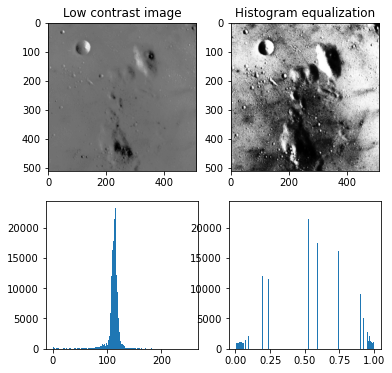

In [79]:
img = data.moon()
plotImgAndHistEq(img)

## Why it works?

As seen in the histogram lab before, the process of histogram stretching involves a gray level transformation (check the stretching function in the last lab, which mapped gray levels 5 - 9 (x-axis) to 2 - 14 (y-axis) ). 

Now, let's consider the cumulative histogram of that data. 

Cumulative what!? Before proceeding further, let us understand what cumulative sum is. Consider an array `[1, 3, 6, 7, 8]`, the cumulative sum simply accumulates the sum as we iterate through the array. So `1` stays `1`; then we encounter `3`, which becomes `1+3 = 4`; then we encounter `6`, which becomes `4+6 = 10`; then we encounter `7`, which becomes `10 + 7 = 17`, and so on...

Numpy has a function `cumsum` that does the job.

In [80]:
help(np.cumsum)

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See :ref:`ufuncs-output-type` for

In [81]:
a = np.array([1, 3, 6, 7, 8])
b = np.cumsum(a)
b

array([ 1,  4, 10, 17, 25])

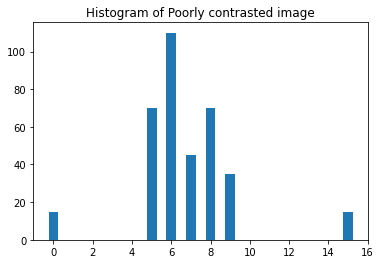

In [82]:
#Toy data with following frequencies (i.e. histogram)
freq = np.array([15, 0, 0, 0, 0, 70, 110, 45, 70, 35, 0, 0, 0, 0, 0, 15])
plt.bar(np.arange(16), freq, 0.5)
plt.title("Histogram of Poorly contrasted image")
plt.show()

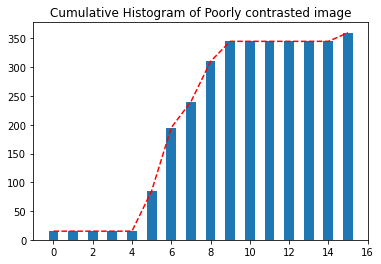

In [83]:
cumulative_histogram = np.cumsum(freq)
plt.plot(cumulative_histogram, 'r--')
plt.bar(np.arange(16), cumulative_histogram, 0.5)
plt.title("Cumulative Histogram of Poorly contrasted image")
plt.show()

The dashed line is simply joining the top of histogram bars. If we scale this so that the y-values are between 0-15, rather than 0-360, then we get the graph:

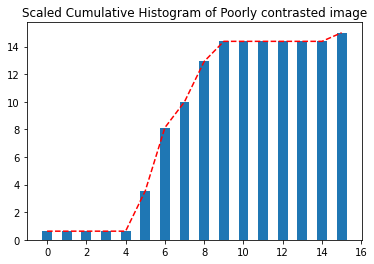

In [84]:
scaled_cumulative_histogram = (cumulative_histogram * 15)/360
plt.plot(scaled_cumulative_histogram, 'r--')
plt.bar(np.arange(16), scaled_cumulative_histogram, 0.5)
plt.title("Scaled Cumulative Histogram of Poorly contrasted image")
plt.show()

Now, note that this highly resembles the stretching function we previously defined! That is, just looking at the dashed line and interpreting this as a mapping, gray levels 5-9 are being roughly mapped to gray levels 2-14! It is giving a recipe for how histogram equalization works internally: that scaled version of cumulative histogram acts as a gray-level transformation. 

Let us apply histogram equalization on an image and check how the cumulative histogram changes. 

Note: histogram is also known as probability density function (pdf) and cumulative histogram is also known as the cumulative distributive function (cdf).

In [85]:
def plotImgHistCDF(im1, im2):
    '''
    Plots images, their histograms, overlaid with CDF (cumulative histogram)
    '''
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5)) #figsize controls relative size of images

    ax[0, 0].imshow(im1, cmap=plt.cm.gray)
    ax[0, 1].hist(im1.flatten(),bins=256) 
    ax[1, 0].imshow(im2, cmap=plt.cm.gray)
    ax[1, 1].hist(im2.flatten(),bins=256)

    #Overlay the cdf on the histograms
    ax_cdf = ax[0, 1].twinx()
    im1_cdf, bins = ex.cumulative_distribution(im1, nbins=256)
    ax_cdf.plot(bins, im1_cdf, 'r')

    ax_cdf = ax[1, 1].twinx()
    im2_cdf, bins = ex.cumulative_distribution(im2, nbins=256)
    ax_cdf.plot(bins, im2_cdf, 'r')

    fig.tight_layout()
    plt.show()

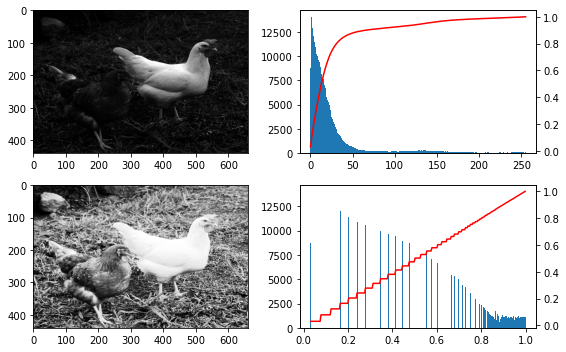

In [35]:
#Apply histogram equalization on the chickens image. 
#And overlay the cumulative histogram on top of the histogram

im = io.imread('chickens.png')
imh = ex.equalize_hist(im) 
plotImgHistCDF(im, imh)

# Recipe for Histogram Equalization
Following is an excerpt from the textbook "A Computational Introduction to Digital Image Processing" by Alasdair McAndrew:

![Recipe for histogram equalization](1600.jpeg)
![Recipe for histogram equalization continued](1601.jpeg)

In [36]:
#helper function
def normalizedSumOfAbsDifference(a, b):
    assert a.shape == b.shape
    return np.sum(np.abs(a-b))/a.size

In [37]:
#helper function
def plotImgAndHist(img, hist):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    #display original and equalized image
    ax[0].imshow(img, cmap = 'gray')
    ax[0].set_title('Image')
    ax[1].bar(range(256), hist)
    ax[1].set_title('Histogram')
    
    fig.tight_layout()
    plt.show()


## Part 1: Compute the histogram by iterating through the image (10 points)
 - You should not use inbuilt functions for this part
 - You can assume 256 bins

In [38]:
def myHistogram(img): #L=256 is the assumption
    '''
    Computes and returns the histogram of img. 
    Histogram is computed for 256 bins (i.e. each gray level gets its own bin) 
        - Does NOT use any inbuilt function TO compute histogram.
    '''
    #ensure img is of type uint8
    assert (img.dtype == 'uint8')

    # YOUR CODE HERE
    histA = np.zeros((256), dtype=int)

    for i in range(len(img)):
        for j in range(len(img[i])):
            histA[img[i][j]] += 1
    return histA

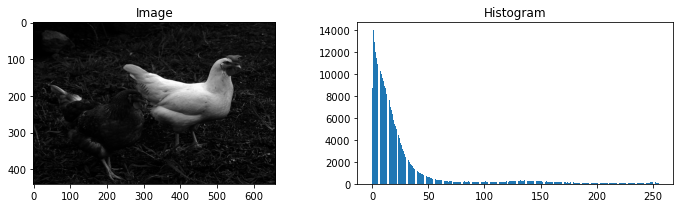

Success!


In [39]:
im = io.imread('chickens.png')
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256)
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

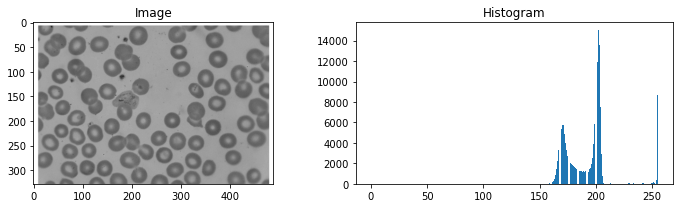

Success!


In [40]:
im = io.imread('blood.png')
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

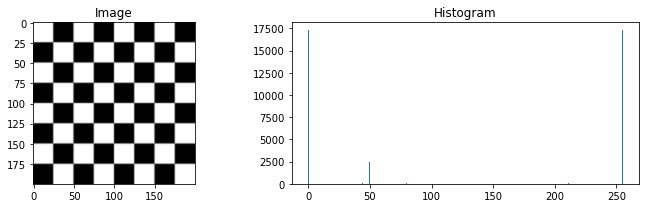

Success!


In [41]:
im = data.checkerboard()
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")


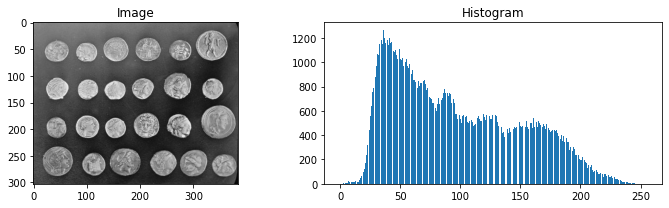

Success!


In [42]:
im = data.coins()
hist1 = myHistogram(im)
hist2, bins = np.histogram(im, bins=256, range = (0, 255))
plotImgAndHist(im, hist1)

assert(np.all(hist1 == hist2))
assert normalizedSumOfAbsDifference(hist1, hist2) == 0
print("Success!")

## Part 2a: Compute the \*mapping\* for histogram equalization using the method shown above (10 points)
 - You should not use inbuilt function for this part

In [57]:
def myHistEq(img): #L=256 is the assumption
    '''
    Computes and returns the gray level mapping based on the method described above. 
        - Calls myHistogram to compute the histogram.
        - Uses np.cumsum to compute cumulative sums.
    Output mapping must be of type uint8
    '''
    #ensure img is of type uint8
    assert (img.dtype == 'uint8')
    
    # YOUR CODE HERE
    newHist = myHistogram(img)
    sumC = np.cumsum(newHist)
    L = 256
    c = np.zeros(L, dtype = 'uint8')
    for i in range(L):
        c[i] = round((sumC[i]/sumC[len(sumC) - 1])*(L-1))
    return c
    

Mapping info: uint8 (256,) 8 255


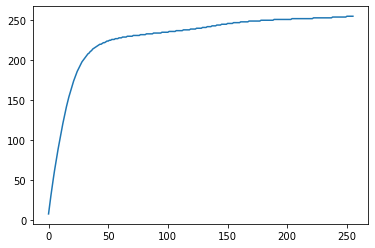

Success!


In [59]:
im = io.imread('chickens.png')
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())

plt.plot(mapping)
plt.show()

assert(mapping.dtype == 'uint8')
assert(mapping[7] == 80)
assert(np.sum(mapping) == 58243)
print("Success!")

Mapping info: uint8 (256,) 0 255


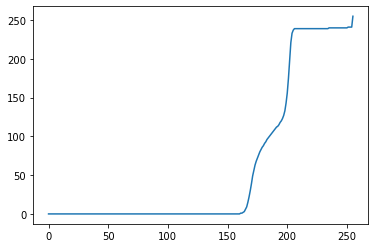

Success!


In [60]:
im = io.imread('blood.png')
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())

plt.plot(mapping)
plt.show()

assert(mapping[150] == 0)
assert(np.sum(mapping) == 16172)
print("Success!")

Mapping info: uint8 (256,) 110 255


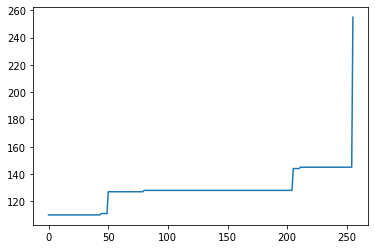

Success!


In [61]:
im = data.checkerboard()
mapping = myHistEq(im)
print("Mapping info:", mapping.dtype, mapping.shape, mapping.min(), mapping.max())
plt.plot(mapping)
plt.show()

assert(mapping[0] == 110)
assert(np.sum(mapping) == 32815)
print("Success!")

## Part 2b: Apply the mapping (obtained in Part 2a) to an image and compare to inbuilt implementation of histogram equalization. (10 points)

(Homegrown) Equalized Image Info uint8 (440, 660) 8 255
(Inbuilt) Equalized Image Info float64 (440, 660) 0.03015840220385675 1.0
Per pixel difference between homegrown and python implementation = 0.20649330130996363


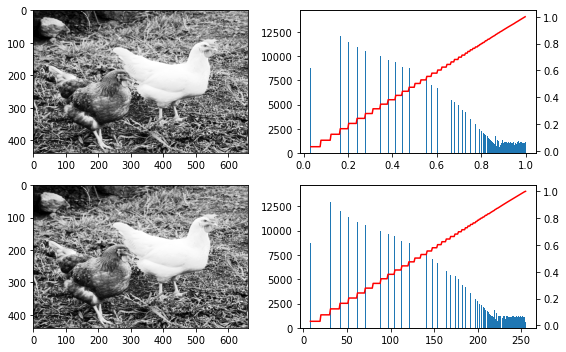

Success!


In [62]:
#our homegrown implementation
im = io.imread('chickens.png')
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.20649330131))
print("Success!")

(Homegrown) Equalized Image Info uint8 (328, 488) 0 255
(Inbuilt) Equalized Image Info float64 (328, 488) 6.24750099960016e-06 1.0
Per pixel difference between homegrown and python implementation = 0.24727456043615972


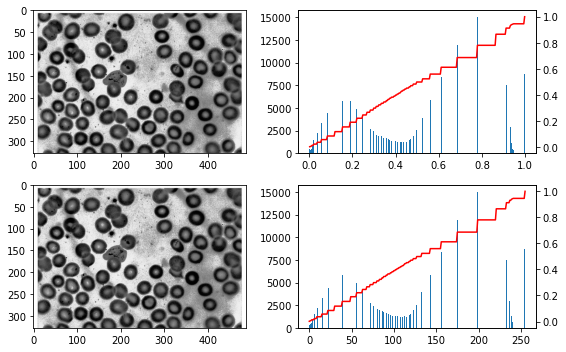

Success!


In [63]:
#our homegrown implementation
im = io.imread('blood.png')
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2472745604))
print("Success!")

(Homegrown) Equalized Image Info uint8 (303, 384) 0 255
(Inbuilt) Equalized Image Info float64 (303, 384) 8.594609460946094e-06 1.0
Per pixel difference between homegrown and python implementation = 0.23666649852398214


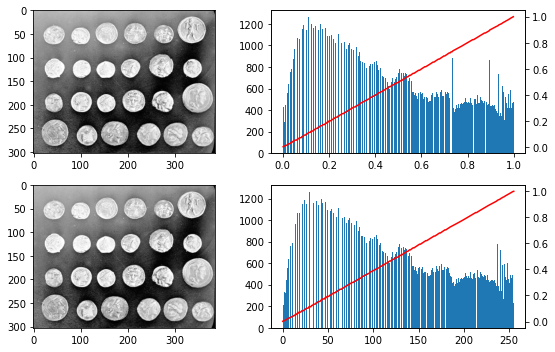

Success!


In [64]:
#our homegrown implementation
im = data.coins()
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2366664985))
print("Success!")

(Homegrown) Equalized Image Info uint8 (512, 512) 0 255
(Inbuilt) Equalized Image Info float64 (512, 512) 0.00091552734375 1.0
Per pixel difference between homegrown and python implementation = 0.2756264947820474


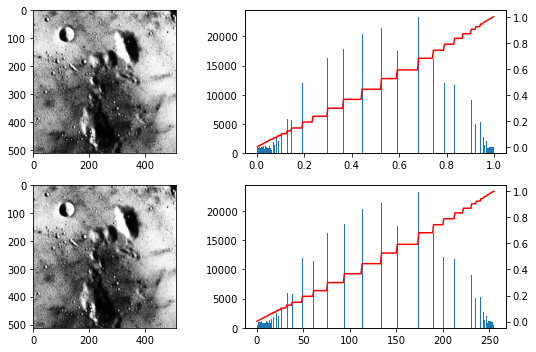

Success!


In [65]:
#our homegrown implementation
im = data.moon()
mapping = myHistEq(im)
im_mapped = mapping[im]
print("(Homegrown) Equalized Image Info", im_mapped.dtype, im_mapped.shape, im_mapped.min(), im_mapped.max())

#python inbuilt implementation
imh = ex.equalize_hist(im)

print("(Inbuilt) Equalized Image Info", imh.dtype, imh.shape, imh.min(), imh.max())
diff = 255*normalizedSumOfAbsDifference(imh, im_mapped/255)
print("Per pixel difference between homegrown and python implementation =", diff)
plotImgHistCDF(imh, im_mapped)
assert(math.isclose(diff, 0.2756264947))
print("Success!")

# Histogram Matching

From this [Reference](http://paulbourke.net/miscellaneous/equalisation/), check out the diagram showing the overview of the process of Histogram Matching:

![Histogram Matching](matchingdiagram.jpeg)

The main idea is to find a mapping for each gray level x<sub>i</sub> (0-255) to a gray level x<sub>j</sub> so that the respective cumulative distribution functions G(x<sub>i</sub>) and H(x<sub>j</sub>) match exactly. Note that, the range of cdf G and H is the same (between 0 and 1) - only then are they "comparable".

In continuous signal processing this matching would be perfect but in discrete case (such as with images), the cdf values G(x<sub>i</sub>) and H(x<sub>j</sub>) will only be "very close to each other". In other words, the goal would be, for each  x<sub>i</sub> (0-255), find a x<sub>j</sub> for which the cdfs G(x<sub>i</sub>) and H(x<sub>j</sub>) are closest to each other and not necessary identical. This is going to be implemented in the function below.

In [66]:
def findClosestIndex(val, inArray):
    '''
    Find and return the index ind in inArray for which val is closest to inArray[ind].
    Example: if inArray = np.array([1, 3, 6, 9, 10, 15]) and val = 5, 
             the closest values to 5 in inArray is 6 and 
             the corresponding index is 2. 
    '''
    
    # YOUR CODE HERE
    idx = (np.abs(inArray - val)).argmin()
    return idx
        

In [68]:
arr = np.array([1, 3, 6, 9, 10, 15])
assert(findClosestIndex(5, arr) == 2)
assert(findClosestIndex(12, arr) == 4)
assert(findClosestIndex(13, arr) == 5)
assert(findClosestIndex(0, arr) == 0)
print("Success! Calls to findClosestIndex pass.")

Success! Calls to findClosestIndex pass.


## Part 3: Compute the \*mapping\* for histogram matching using the method shown above (20 points)
 - You should not use inbuilt function for this part

In [70]:
def myHistMatching(img1, img2): #assumes L=256 
    '''
    Computes and returns the gray level mapping that matches histogram of img1 to that of img2 (reference)
        - Calls myHistogram to compute the histogram.
        - Uses np.cumsum to compute cumulative sums.
        - Calls findClosestIndex to compute the mapping for each gray level
    Output mapping must be of type uint8
    '''
    
    #ensure imgs are of type uint8
    assert (img1.dtype == 'uint8')
    assert (img2.dtype == 'uint8')
    
    # YOUR CODE HERE
    hist1 = myHistogram(img1)
    hist2 = myHistogram(img2)
    a = np.cumsum(hist1)
    b = np.cumsum(hist2)
    mappingArr = np.zeros((256), dtype = 'uint8')
    #divide each value in the array by the largest in the array, will give only values 0-1
    norm1 = a/max(a)
    norm2 = b/max(b)
    for i in range(len(mappingArr)):
        mappingArr[i] = findClosestIndex(norm1[i], norm2)
    return mappingArr


Image 1: uint8 (440, 660) 0 255
Image 2: uint8 (328, 488) 113 255


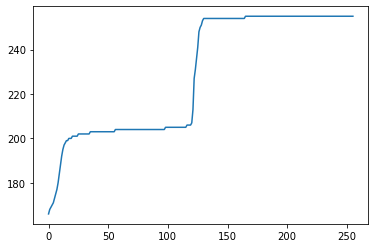

Success!


In [71]:
im1 = io.imread('chickens.png')
im2 = io.imread('blood.png')#data.checkerboard()#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
plt.plot(mapping)
plt.show()

assert(mapping.dtype == 'uint8')
assert(mapping[0] == 166)
assert(np.sum(mapping) == 58523)

print("Success!")

Matched image -homegrown-: (440, 660) uint8 166 255
Matched image -inbuilt-: (440, 660) float64 165.52806190896652 255.0
Average difference between homegrown and inbuilt implementation= 0.23799031032244256


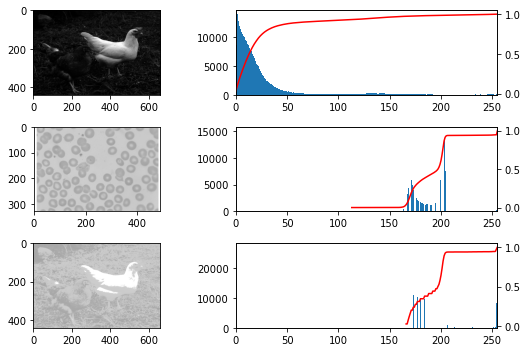

Success!


In [72]:
matchedImage1 = mapping[im1]
print("Matched image -homegrown-:", matchedImage1.shape, matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())

matchedImage2 = ex.match_histograms(im1, im2)
print("Matched image -inbuilt-:", matchedImage2.shape, matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and inbuilt implementation=", diff)

plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2379903103))
print("Success!")

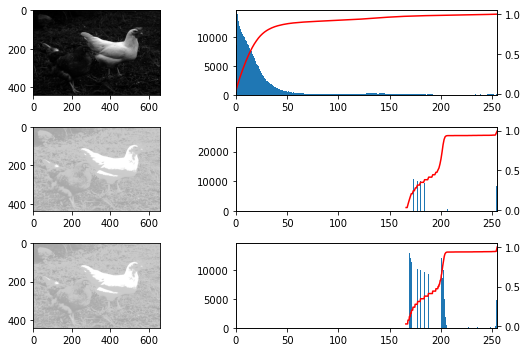

In [73]:
#Compare the two matched images: homegrown vs in-built
plotHistMatchingCDF(im1, matchedImage1, matchedImage2)

Image 1: uint8 (440, 660) 0 255
Image 2: uint8 (303, 384) 1 252
Matched image -homegrown-: uint8 27 252
Matched image -inbuilt-: float64 26.777765096856005 252.0
Average difference between homegrown and python implementation= 0.24762424320325702


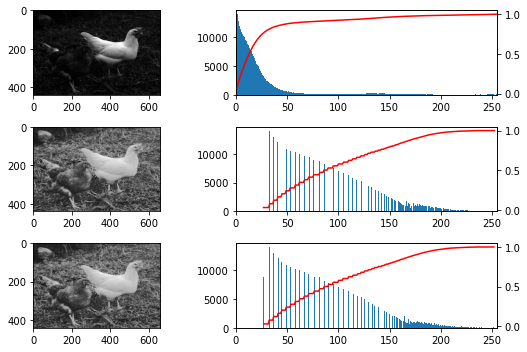

Success!


In [74]:
im1 = io.imread('chickens.png')
im2 = data.coins()
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)

matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2476242432))
print("Success!")

Image 1: uint8 (440, 660) 0 255
Image 2: uint8 (200, 200) 0 255
Matched image -homegrown-: uint8 0 255
Matched image -inbuilt-: float64 0.0 255.0
Average difference between homegrown and python implementation= 5.806329865243045


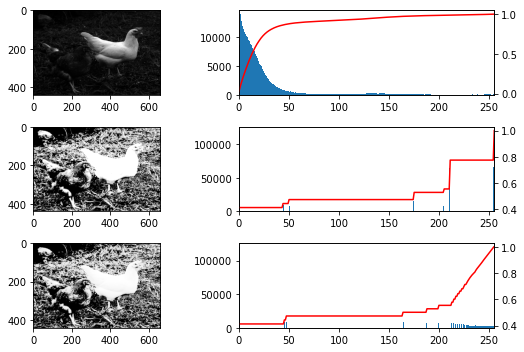

Success!


In [75]:
im1 = io.imread('chickens.png')
im2 = data.checkerboard()#io.imread('eagle.png')#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 5.806329865))
print("Success!")

Image 1: uint8 (328, 488) 113 255
Image 2: uint8 (303, 384) 1 252
Matched image -homegrown-: uint8 1 252
Matched image -inbuilt-: float64 1.0 252.0
Average difference between homegrown and python implementation= 0.2362946726895882


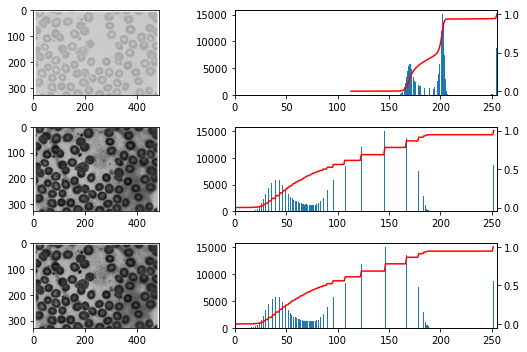

Success!


In [76]:
im1 = io.imread('blood.png')
im2 = data.coins()#io.imread('eagle.png')#
print("Image 1:", im1.dtype, im1.shape, im1.min(), im1.max())
print("Image 2:", im2.dtype, im2.shape, im2.min(), im2.max())
mapping = myHistMatching(im1, im2)
matchedImage1 = mapping[im1]
matchedImage2 = ex.match_histograms(im1, im2)

print("Matched image -homegrown-:", matchedImage1.dtype, matchedImage1.min(), matchedImage1.max())
print("Matched image -inbuilt-:", matchedImage2.dtype, matchedImage2.min(), matchedImage2.max())

diff = normalizedSumOfAbsDifference(matchedImage1, matchedImage2)
print("Average difference between homegrown and python implementation=", diff)

plotHistMatchingCDF(im1, matchedImage1, matchedImage2)
#plotHistMatchingCDF(im1, im2, matchedImage1)
assert(math.isclose(diff, 0.2362946726))
print("Success!")